# 独自データの分類 - 改良版


In [6]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.dataset import concat_examples
import inspect
from jupyterthemes import jtplot
jtplot.style()
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

train, test = datasets.get_mnist()
train_iter = iterators.SerialIterator(train, batch_size=100, shuffle=True)
test_iter = iterators.SerialIterator(train, batch_size=100, shuffle=False, repeat=False)


## データ用意

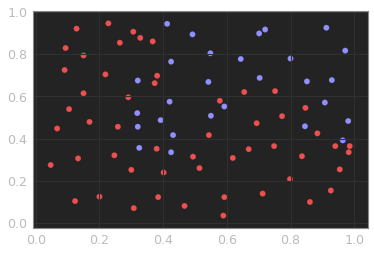

In [7]:
file = open("sample1.txt", mode='r')
lines = file.readlines()

file.close()

train_pos = []
t_label = []

for line in lines:
    vals = line.split(",")
    train_pos.append([int(vals[0]),480-int(vals[1])])
    t_label.append(int(vals[2]))

#train_array
#t_array

#デフォルトでtrain_posは座標そのままなので正規化する
sample_train = np.array(train_pos, np.float32) / np.array([640, 480], np.float32)
sample_train_t = np.array(t_label, np.int32)

import random
#暫定的に何個かサンプリングしてテスト用データとする
test_pos = []
test_t_label = []
for i in range(20) :
    idx = random.randrange(0, sample_train.shape[0])
    test_pos.append(train_pos[idx])
    test_t_label.append(t_label[idx])
    
sample_test = np.array(test_pos, np.float32) / np.array([640, 480], np.float32)
sample_test_t = np.array(test_t_label, np.int32)

#学習用データの表示
cm = generate_cmap(['#EE5050', '#9090FF'])
plt.scatter(sample_train[:,0], sample_train[:,1], c=sample_train_t, cmap=cm)

#コメントアウトを外してテストデータの表示
cm_test = generate_cmap(['#50EE50', '#EE50EE'])
#plt.scatter(sample_test[:,0], sample_test[:,1], c=sample_test_t, cmap=cm_test)

#格子点サンプルの用意
xx, yy = np.meshgrid(np.arange(0,1.0,0.01), np.arange(0,1.0,0.01))
sample_mesh = np.array(np.c_[xx.ravel(), yy.ravel()], np.float32)

from chainer.datasets import tuple_dataset

#最後に、iterで取り出しやすいようTupleDatasetの形にする
train = tuple_dataset.TupleDataset(sample_train, sample_train_t)
test = tuple_dataset.TupleDataset(sample_test, sample_test_t)

### モデルの定義

In [8]:
class MLP(Chain):
    def __init__(self, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 100)
            self.l2 = L.Linear(None, 100)
            self.l3 = L.Linear(None, 100)
            self.l4 = L.Linear(None, 80)
            self.l5 = L.Linear(None, 50)
            self.l6 = L.Linear(None, 20)
            self.l7 = L.Linear(None, n_out)
            
            
    def __call__(self, x):
        #層の結合結果に、活性化関数をかませる
        h1 = F.tanh(self.l1(x))
        h2 = F.tanh(self.l2(h1))
        h3 = F.tanh(self.l3(h2))
        h4 = F.tanh(self.l4(h3))
        h5 = F.tanh(self.l5(h4))
        h6 = F.tanh(self.l6(h5))
        y = self.l7(h6)
        return y
    
class Classifier(Chain):
    def __init__(self, predictor):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor
            
    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.softmax_cross_entropy(y, t)
        accuracy = F.accuracy(y, t)
        report({'loss':loss, 'accuracy':accuracy})        
        return loss

## ビギナー向けチュートリアルに沿った実装

https://qiita.com/mitmul/items/eccf4e0a84cb784ba84a

2 Iteratorぐらいから

サンプルに対してiteratorを定義する

In [9]:
len(train)

train_batchsize = 1

train_iter = iterators.SerialIterator(train, train_batchsize)
test_iter = iterators.SerialIterator(test, 20, repeat=False, shuffle=False)

81

optimizerを定義し、モデルをセットする

In [10]:
#ここで学習率の設定
optimizer = optimizers.SGD(lr = 0.005)
#上で定義したモデルのインスタンス作成 最終出力2
model = MLP(2)
optimizer.setup(model)


### 学習ループ

1. 入力をmodelで計算して出力yを得る
2. yからloss値を計算する　今回はsoftmax_cross_entropyを使う
3. loss値に対する各パラメータの勾配を計算する
4. optimizerでupdate

In [11]:

max_epoch = 200

while train_iter.epoch < max_epoch:
    #バッチを1つ取り出す
    train_batch = train_iter.next()
    #学習用データとラベルを一緒にとってしまっているのでバラす
    x, t = concat_examples(train_batch)
    #出力を得る
    y = model(x)
    #lossを計算
    loss = F.softmax_cross_entropy(y, t)    
    #新しく勾配計算を始めるごとに初期化
    model.cleargrads()
    
    #lossに対して各パラメータの勾配を計算
    loss.backward()
    #勾配計算済みなので引数なしでupdateを呼び出す
    optimizer.update() 
    
    #テストデータに対してモデルを適用し,accuracyとlossを算出
    #モデルの性能が上がっていることを確かめる
    test_losses = []
    test_accuracies = []
    if train_iter.is_new_epoch:
        while True:
            test_batch = test_iter.next()
            x, t = concat_examples(test_batch)
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)    
            accuracy = F.accuracy(y, t)
            print("Now at ", train_iter.epoch)
            print("loss:", loss)
            print("accuracy:", accuracy)
            
            if test_iter.is_new_epoch:
                test_iter.reset()
                break


Now at  1
loss: variable(0.6082148551940918)
accuracy: variable(0.8500000238418579)
Now at  2
loss: variable(0.5855560898780823)
accuracy: variable(0.75)
Now at  3
loss: variable(0.5857549905776978)
accuracy: variable(0.699999988079071)
Now at  4
loss: variable(0.5327829122543335)
accuracy: variable(0.699999988079071)
Now at  5
loss: variable(0.5205835103988647)
accuracy: variable(0.75)
Now at  6
loss: variable(0.5380578637123108)
accuracy: variable(0.699999988079071)
Now at  7
loss: variable(0.5135419368743896)
accuracy: variable(0.75)
Now at  8
loss: variable(0.5689957141876221)
accuracy: variable(0.75)
Now at  9
loss: variable(0.4734382629394531)
accuracy: variable(0.75)
Now at  10
loss: variable(0.46751806139945984)
accuracy: variable(0.699999988079071)
Now at  11
loss: variable(0.5242945551872253)
accuracy: variable(0.75)
Now at  12
loss: variable(0.4793643057346344)
accuracy: variable(0.699999988079071)
Now at  13
loss: variable(0.6259851455688477)
accuracy: variable(0.6000000238

### 作成モデルを格子点に適用して可視化

作成したデータ点-クラスラベルを学習したモデルを用いて

各格子点をどのようにクラス分けするか見る

これによって分類境界を見ることができる

numpy.ndarray

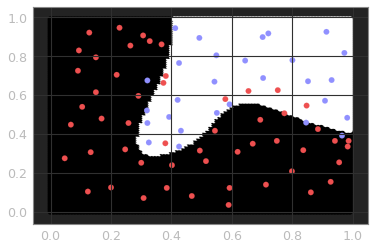

In [12]:
y = model(sample_mesh)

predict_label = F.argmax(y, axis=1).data
type(predict_label)

#テスト用データの表示
cm = generate_cmap(['#000000', '#FFFFFF'])
plt.scatter(sample_mesh[:,0], sample_mesh[:,1], c=predict_label, cmap=cm)

cm = generate_cmap(['#EE5050', '#9090FF'])
plt.scatter(sample_train[:,0], sample_train[:,1], c=sample_train_t, cmap=cm)

#テスト用データの表示
#plt.scatter(sample_test[:,0], sample_test[:,1], c=sample_test_t, cmap=cm_test)


黒 = 学習用データクラス0

白 = 学習用データクラス1

（表示している場合）緑と桃はテスト用データ…accuracyとlossの途中経過レポートに使われている

赤 = 学習したモデルが判定したクラス0

青 = 学習したモデルが判定したクラス1

### 知見など

今回の用にサンプル数が少ないと、バッチサイズを大きくしすぎるとコーナーケースのlossが潰れる？（図右端のクラス1（青）など）

やはり学習率は重要っぽい

他中間ノード数などで調節可能

学習率=0.01～0.005で、学習数（＝データ数×エポック数）が多くないと全然分類できない模様？

80サンプルで200epoch

200サンプルで40epochぐらいで見た目よい結果


活性化関数はtanhがよいのかも？

https://qiita.com/miyamotok0105/items/3435930cc04650bce54d